In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels as sm

import seaborn as sns

In [50]:
!sbt run

[info] Loading global plugins from /Users/drpugh/.sbt/0.13/plugins
[info] Loading project definition from /Users/drpugh/Research/scalabm/models-library/gode-sunder/project
[info] Set current project to gode-sunder-model (in build file:/Users/drpugh/Research/scalabm/models-library/gode-sunder/)
[info] Compiling 4 Scala sources to /Users/drpugh/Research/scalabm/models-library/gode-sunder/target/scala-2.11/classes...
[info] Running GodeSunderApp 
[info] -XX:InitialHeapSize=3226678064 -XX:MaxHeapSize=6442450944 -XX:MaxNewSize=3221225472 -XX:NewSize=3221225472 -XX:+PrintCommandLineFlags -XX:-UseBiasedLocking -XX:+UseCompressedClassPointers -XX:+UseCompressedOops -XX:+UseCondCardMark -XX:+UseNUMA -XX:+UseParallelGC 
[info] [INFO] [02/19/2016 13:14:58.693] [gode-sunder-model-akka.actor.default-dispatcher-4] [akka://gode-sunder-model/user/$q] Message [markets.participants.LiquiditySupplier$SubmitLimitBidOrder$] from Actor[akka://gode-sunder-model/deadLetters] to Actor[akka://gode-sunder-model/

## Importing the raw JSON data

In [51]:
tmp_df = pd.read_json('./data/Gpi2.json', orient='records')
data = tmp_df.iloc[::-1].set_index('timestamp')

In [52]:
data.head()

,askPrice,bidPrice,price,quantity
timestamp,,,,
2016-02-19 13:13:58.245,3,159,3,1
2016-02-19 13:13:58.266,2,26,26,1
2016-02-19 13:13:58.267,9,84,9,1
2016-02-19 13:13:58.267,42,120,42,1
2016-02-19 13:13:58.267,61,142,61,1


In [53]:
data.tail()

,askPrice,bidPrice,price,quantity
timestamp,,,,
2016-02-19 13:14:58.749,134,155,134,1
2016-02-19 13:14:58.749,46,131,131,1
2016-02-19 13:14:58.749,14,52,52,1
2016-02-19 13:14:58.749,59,84,59,1
2016-02-19 13:14:58.749,70,160,70,1


In [54]:
data.describe()

,askPrice,bidPrice,price,quantity
count,1227973.000000,1227973.000000,1227973.000000,1227973
mean,78.171983,121.989818,100.078143,1
std,45.005486,44.990396,31.006416,0
min,1.000000,26.000000,3.000000,1
25%,39.000000,83.000000,75.000000,1
50%,78.000000,122.000000,100.000000,1
75%,117.000000,161.000000,126.000000,1
max,160.000000,199.000000,160.000000,1


### Compute the bid-ask spread...

    spread = bidPrice - askPice

In [55]:
data['spread'] = data.bidPrice - data.askPrice

In [56]:
data.spread.describe()

count    1227973.000000
mean          43.817836
std           29.919439
min            1.000000
25%           20.000000
50%           39.000000
75%           62.000000
max          156.000000
Name: spread, dtype: float64

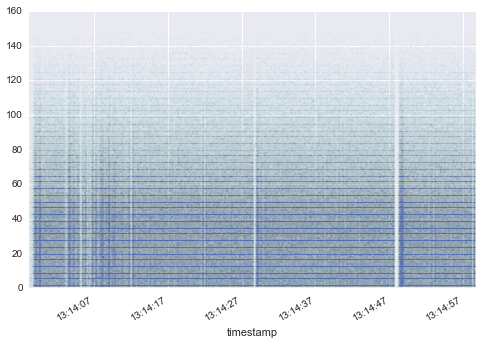

In [57]:
data.spread.plot(linestyle='none', marker='o', markersize=1, alpha=0.05)
plt.show()

<h2> Compute raw returns </h2>

$$ r_{t+k} = \frac{p_{t+k} - p_{t}}{p_{t}} = \frac{\Delta p_{t+k}}{p_{t}}$$ 

Note that raw returns are bounded below! Bounds on price (at least in these simulations!) are $1 \le p_t \le 200$. Therefore lower bound on raw returns is...

$$ \underline{r} = \frac{1 - 200}{200} \approx -1. $$

Similarly, then upper bound on raw returns is...

$$ \underline{r} = \frac{200 - 1}{1} = 199. $$


In [60]:
data['raw_returns'] = data.price.pct_change(periods=1)

In [61]:
data.raw_returns.describe()

count    1227972.000000
mean           0.100917
std            0.509938
min           -0.734177
25%           -0.229730
50%            0.000000
75%            0.293333
max            7.666667
Name: raw_returns, dtype: float64

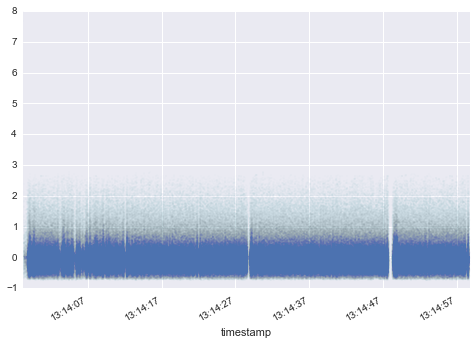

In [62]:
data.raw_returns.plot(linestyle='none', marker='o', markersize=1, alpha=0.05)
plt.show()

## Compute logarithmic returns

Starting from raw returns, $r_{t+k}$ we see that...

$$ 1 + r_{t+k} = 1 + \frac{p_{t+k} - p_t}{p_t} = \frac{p_{t+k}}{p_t} $$

...taking logs yields...

$$ \ln \big(1 + r_{t+k}\big) = \ln p_{t+k} - \ln p_t = \Delta \ln p_{t+k} $$

...since $\ln \big(1 + r_{t+k}\big) \approx r_{t+k}$ for $r << 1$ we should expect that raw and logarithmic return formulas should yields similar results for "small" returns.


In [63]:
data['log_returns'] = np.log(1 + data.raw_returns)

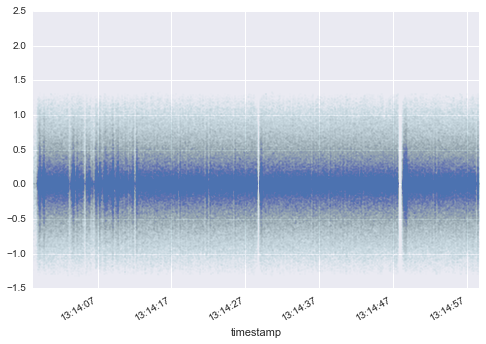

In [64]:
data.log_returns.plot(linestyle='none', marker='o', markersize=1, alpha=0.05)
plt.show()

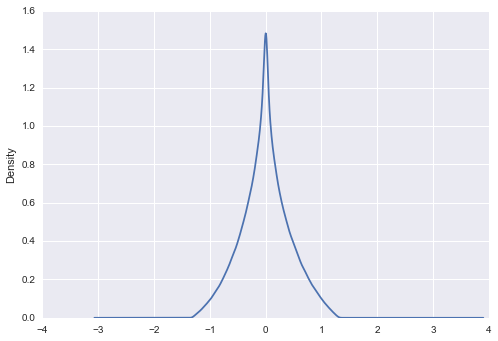

In [65]:
data.log_returns.dropna().plot(kind='kde')
plt.show()

<h3> Price impact </h3>

In [66]:
data['mid_price'] = 0.5 * (data.askPrice + data.bidPrice)

How to best measure effective size? Particularly of ask orders!

In [67]:
data['effective_size'] = data.quantity

incoming_ask_orders = data.bidPrice == data.price
data.loc[incoming_ask_orders, 'effective_size'] *= -data.loc[incoming_ask_orders, 'askPrice']

incoming_bid_orders = data.askPrice == data.price
data.loc[incoming_bid_orders, 'effective_size'] *= data.loc[incoming_bid_orders, 'bidPrice']

Compute the measure of price impact: $\Delta \ln$ `mid_price`...

In [68]:
data['price_impact'] = np.log(data.mid_price).diff()

In [69]:
data[incoming_ask_orders].head()

,askPrice,bidPrice,price,quantity,spread,raw_returns,log_returns,mid_price,effective_size,price_impact
timestamp,,,,,,,,,,
2016-02-19 13:13:58.266,2,26,26,1,24,7.666667,2.159484,14.0,-2,-1.755392
2016-02-19 13:13:58.269,33,68,68,1,35,0.079365,0.076373,50.5,-33,-0.827297
2016-02-19 13:13:58.269,41,54,54,1,13,-0.205882,-0.230524,47.5,-41,-0.061244
2016-02-19 13:13:58.271,9,107,107,1,98,-0.053097,-0.054559,58.0,-9,-0.855882
2016-02-19 13:13:58.271,15,83,83,1,68,-0.371212,-0.463961,49.0,-15,-1.024504


/Users/drpugh/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


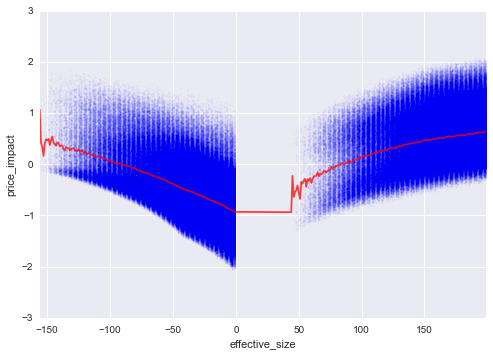

In [70]:
# incoming bid orders
fig, ax = plt.subplots(1, 1)
grouped_data = data.groupby("effective_size")
grouped_data.price_impact.mean().plot(color='r', alpha=0.75, ax=ax)
ax.scatter(data.effective_size, data.price_impact, edgecolor='b', s=1, alpha=0.05)
ax.set_ylabel("price_impact")
plt.show()

## Cumulative distributions

In [48]:
ecdfs = {} 
for column_name in ['raw_returns', 'log_returns']:
    ecdfs[column_name] = sm.distributions.ECDF(data[column_name].abs())

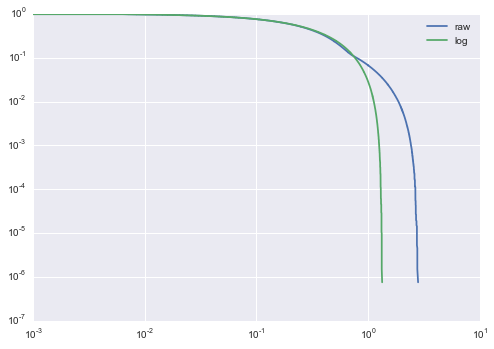

In [49]:
plt.plot(ecdfs['raw_returns'].x, 1 - ecdfs['raw_returns'].y, label='raw')
plt.plot(ecdfs['log_returns'].x, 1 - ecdfs['log_returns'].y, label='log')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()